# Hello World

It is not really established yet, what the quantum analogy of the classical `print("Hello world")` is. I will define here the "Hello world" as the task to build an arbitrary circuit with rotations and an entangling gate on 2 qubits, I will print the circuit and sample from it.

## Tensorflow Quantum "Hello World"

Since Tensorflow Quantum (tfq) does all the quantum part on google's own quantum platform Cirq, the "Hello world" example can be done without using tfq. 

In [25]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy                            # Sympy is for symbolic math
import numpy as np

from cirq.contrib.svg import SVGCircuit # to print the circuit

- Define symbolic variables, which will be the parameters of the rotations
- Define qubits q0 and q1
- Define a circuit with a Rx rotations on each qubit followed by CNOT
- Print the circuit with the Cirquit native `SVGCircuit`

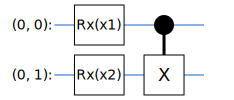

In [26]:
x1, x2 = sympy.symbols('x1 x2')             # Define symbolic parameters x1, x2

q0, q1 = cirq.GridQubit.rect(1,2)          # Define two qubits on grid

# Define a circuit
tf_circuit = cirq.Circuit(
    cirq.rx(x1).on(q0),
    cirq.rx(x2).on(q1), 
    cirq.CNOT(control=q0, target=q1)
)

SVGCircuit(tf_circuit)                         # Print circuit

- Or simply print the circuit

In [27]:
print(tf_circuit)

(0, 0): ───Rx(x1)───@───
                    │
(0, 1): ───Rx(x2)───X───


### How to measure an output?

In the cirq simulator we can get the state vector as an output and after that we can calculate any observable that we want.

#### Define the Cirq simulator and the resolver

The resolver sets the symbolic values of the rotation angles to a real value.

In [28]:
simulator = cirq.Simulator()
resolver = cirq.ParamResolver({x1: 0.5, x2: -0.5}) # Set symbolic parameters to values 0.5 and -0.5

#### Do a measurement

Measurements in Cirq can be by adding `cirq.measure()` and define which qubit we want to measure. The "key" in the measurement can be set arbitrary and is just to find the histogram later. Cirq measurements can be done the `.run` command from the `cirq.Simulator()`.

In [29]:
resolved_circuit = cirq.resolve_parameters(tf_circuit, resolver) # Resolve sympy values in circuit
resolved_circuit.append(cirq.measure(q0, key='some_key'))            # Add a measurement in Z direction on qubit 0
results = simulator.run(resolved_circuit, repetitions=100)    # Run a simulation of this circuit 100 times
print(results.histogram(key='some_key'))                             # Get measurement statistics

Counter({0: 90, 1: 10})


#### Get measurement by simulating the state vector

Instead of running the measurement 100 times we can also get analytic results from the `.simulate` command from the `cirq.Simulator()`.
The measurement direction can here be specified as an arbitrary combination of Pauli operators.

In [30]:
output_state_vector = simulator.simulate(tf_circuit, resolver).final_state # simulate state vector

z0 = cirq.Z(q0)              # Define measurement direction in Z direction

qubit_map = {q0: 0, q1: 1}   # Define which qubits are involved in measurement

z0.expectation_from_wavefunction(output_state_vector, qubit_map).real

0.8775825500488281

Here is another example for a measurement in $0.5 Z_0 + X_1$ direction

In [31]:
z0x1 = 0.5 * z0 + cirq.X(q1)

z0x1.expectation_from_wavefunction(output_state_vector, qubit_map).real

0.43879127502441406

## Pennylane "Hello World"

Pennylane is "hardware agnostic", which means we do not have to stick to one quantum environment like Cirq. For every environment Qiskit, Cirq, Forest we basically just have to change one line of code, the `qml.device()`.

In [32]:
import pennylane as qml
from pennylane import numpy as np

### Define a device

This is basically the whole magic of pennylane. By defining a device we can access all possible quantum hardware platforms and simulators. For more information see [here](https://pennylane.ai/plugins.html).

We will start with the `qiskit.aer` device that can be installed via `pip install pennylane-qiskit`.

In [33]:
dev1 = qml.device("qiskit.aer", wires=2)

In [34]:
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RX(params[1], wires=1)
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.PauliZ(0))

Pennylane allows us to use wrappers, to directly define a `circuit()` for a certain device `dev1`. To do so you can start the above definition of the circuit with `@qml.qnode(dev)`. This will look the following way:

```
@qml.qnode(dev1)
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))
```
    
I recommend doing this, if you anyway stick to the same device. I will not do it in this tutorial, because I will change the device many times.

To set the device for the circuit we can also do the following and evaulate it directly for the given parameters

In [35]:
q_circuit = qml.QNode(circuit, dev1)

params = np.array([0.5, -0.5])
q_circuit(params)

0.861328125

To print the circuit with `qiskit.aer` we can directly do the following:

In [36]:
dev1._circuit.draw()

┌─────────┐      ┌─┐   
q_0: |0>┤ Rx(0.5) ├───■──┤M├───
        ├─────────┴┐┌─┴─┐└╥┘┌─┐
q_1: |0>┤ Rx(-0.5) ├┤ X ├─╫─┤M├
        └──────────┘└───┘ ║ └╥┘
 c_0: 0 ══════════════════╩══╬═
                             ║ 
 c_1: 0 ═════════════════════╩═

With the `default.qubit` the output looks the following way. 

In [37]:
dev1 = qml.device("default.qubit", wires=2)
q_circuit = qml.QNode(circuit, dev1)
params = np.array([0.5, -0.5])
q_circuit(params)
print(q_circuit.draw())

 0: ──RX(0.5)───╭C──┤ ⟨Z⟩ 
 1: ──RX(-0.5)──╰X──┤     



We can evaluate the circuit like before with the parameters 0.5 and -0.5

In [38]:
params = np.array([0.5, -0.5])
q_circuit(params)

0.8775825618903726

And we can also sample the measurement outputs by changing the return line of the circuit function from `qml.expval()` to `qml.sample()`

In [39]:
def circuit_sample(params):
    qml.RX(params[0], wires=0)
    qml.RX(params[1], wires=1)
    qml.CNOT(wires=[0,1])
    return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))

dev2 = qml.device("default.qubit", wires=2)
q_circuit = qml.QNode(circuit_sample, dev2)
params = np.array([0.5, -0.5])
q_circuit(params)

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1, -1,  1, ...,  1,  1,  1]])

And the wavefunction can as well be accessed with the `default.qubit`

In [41]:
q_circuit(params)
print(dev1.state)

[0.93879128+0.j         0.        +0.23971277j 0.06120872+0.j
 0.        -0.23971277j]


To change the measurement of the circuit, we have to redefine the circuit. It seems there is no way around this. We can change the last line of the `def circuit_sample` function to e.g. `return qml.expval(qml.PauliZ(0) @ qml.PauliX(1))` to measure the correlation $\langle Z \otimes X \rangle$.